<a id=top-page></a>
# `pykitPIV` demo: Upload and test the trained RL model

In this Jupyter notebook, we upload the trained reinforcement learning (RL) model.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#init">Initializations
</a></li>
        <ul>
        <li><a href="#prepare-specs">Prepare specifications for pykitPIV parameters</a></li>
        <li><a href="#prepare-inference">Prepare the CNN-based inference model for PIV images:</a></li>
        </ul>
    <li><a href="#RL-env">Create the RL environment</a></li>
    <li><a href="#upload-network">Upload the Q-network trained on the cluster</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgentSingleDQN, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
from pykitPIV import FlowField
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

2025-08-12 13:33:31.536024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
action_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap_actions = ListedColormap(action_colors)

In [4]:
cmap = cmc.roma

In [5]:
interrogation_window_size = (40,40)
interrogation_window_size_buffer = 0

<a id='init'></a>

***

## Initializations

[Go to the top](#top-page)

<a id='prepare-specs'></a>

### Prepare specifications for pykitPIV parameters

[Go to the top](#top-page)

In [6]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
min_diameter=0.01,
seeding_mode='random',
dtype=<class 'numpy.float64'>,
random_seed=None)


In [7]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
dtype=<class 'numpy.float64'>,
random_seed=None)


In [8]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False,
dtype=<class 'numpy.float64'>)


<a id='prepare-inference'></a>

### Prepare the CNN-based inference model for PIV images

[Go to the top](#top-page)

In [9]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [10]:
model_file = '../docs/data/Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../docs/data/Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [11]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


<a id='RL-env'></a>

***

## Create the RL environment

[Go to the top](#top-page)

Upload the displacement field:

In [12]:
u = pd.read_csv('../docs/data/final-u.csv', sep = ',', header=None).to_numpy()
v = pd.read_csv('../docs/data/final-v.csv', sep = ',', header=None).to_numpy()

In [15]:
user_velocity_field = np.zeros((1,2,200,300))
user_velocity_field[0,0,:,:] = u
user_velocity_field[0,1,:,:] = v

user_flowfield = FlowField(n_images=1,
                           size=(200, 300),
                           size_buffer=0,
                           time_separation=2,
                           random_seed=100)

user_flowfield.upload_velocity_field(user_velocity_field)

Define the cues that the RL agent effectively senses and learns from:

In [16]:
cues_obj = Cues(sample_every_n=10, 
                normalize_displacement_vectors=False)
cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium` environment:

In [17]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=0,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=None,
             inference_model=None,
             user_flowfield=user_flowfield,
             random_seed=None)

In [18]:
camera_position, cues = env.reset()

In [19]:
cues.shape

(1, 32)

In [20]:
divergence = np.abs(compute_divergence(user_flowfield.velocity_field)[0,:,:])

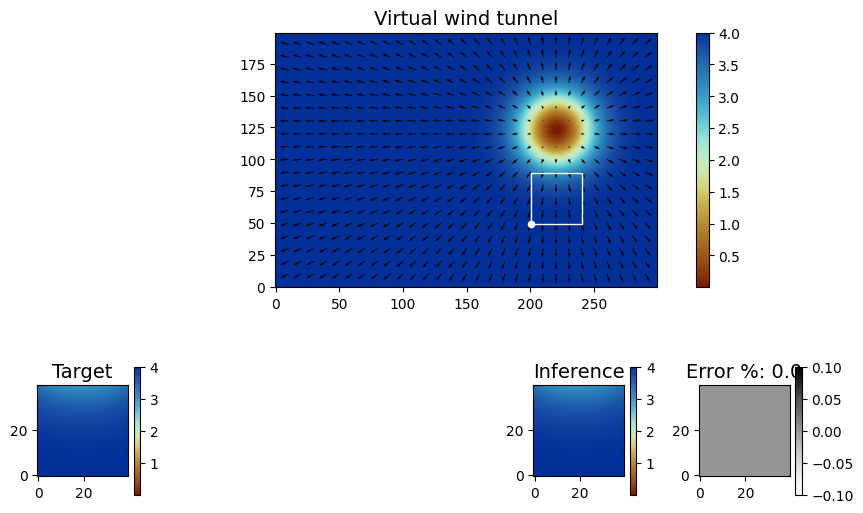

In [21]:
if save_images: filename = 'ml_PIVEnv_render.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmap,
                 add_quiver=True,
                 quiver_step=10,
                 quiver_color='k',
                 add_streamplot=False,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename=filename)

<a id='upload-network'></a>

***

## Upload the Q-network trained on the cluster

[Go to the top](#top-page)

Define the Q-network:

In [22]:
size_of_hidden_unit = int(env.n_cues/2)
size_of_hidden_unit = 64
size_of_hidden_unit

64

In [23]:
class QNetwork(tf.keras.Model):

    def __init__(self, n_actions, kernel_initializer):

        super(QNetwork, self).__init__()

        self.dense1 = tf.keras.layers.Dense(env.n_cues, activation='relu', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.dense3 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='relu', kernel_initializer=kernel_initializer)

    def call(self, state):

        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

Upload the weights and biases for the Q-network:

In [24]:
trained_q_network = QNetwork(n_actions=env.n_actions, kernel_initializer = tf.keras.initializers.RandomUniform)
_ = trained_q_network(tf.ones((1, env.n_cues)))

In [25]:
trained_q_network.load_weights('../docs/data/SingleDQN.keras')

Make inference:

In [26]:
(_, _, H, W) = env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

41600


In [27]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = env.reset(imposed_camera_position=camera_position)
        q_values = trained_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 195.8 sec.


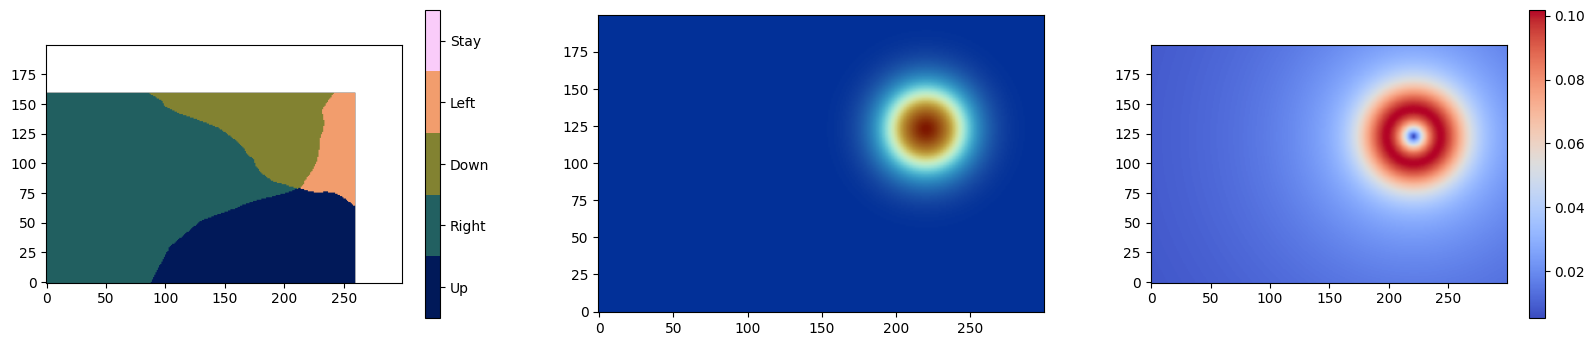

In [28]:
figure = plt.figure(figsize=(20, 4))
spec = figure.add_gridspec(ncols=5, nrows=1, width_ratios=[1,0,1,0,1], height_ratios=[1])

figure_a = figure.add_subplot(spec[0,0])
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(env.action_to_verbose_direction.values()))

figure_b = figure.add_subplot(spec[0,2])
plt.imshow(user_flowfield.velocity_field_magnitude[0,0,:,:], origin='lower', cmap=cmap)

figure_c = figure.add_subplot(spec[0,4])

plt.imshow(np.abs(compute_divergence(user_flowfield.velocity_field)[0,:,:]), origin='lower', cmap='coolwarm')
plt.colorbar()

if save_images: plt.savefig('policy-for-env.png', dpi=300, bbox_inches='tight')

<a id='testing-in-new-flow-regimes'></a>

***

## Test the learned policy in new flow regimes

[Go to the top](#top-page)

In [183]:
random_seed = 30

Here, we create a new virtual wind tunnel environment that will allow us to test the learned policy in scenarios where the source can be placed in an arbitrary location.

In [184]:
particle_spec = ParticleSpecs(diameters=1,
                              distances=2,
                              densities=0.4,
                              diameter_std=0,
                              seeding_mode='random', 
                              random_seed=random_seed)

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=1,
distances=2,
densities=0.4,
diameter_std=0,
min_diameter=0.01,
seeding_mode='random',
dtype=<class 'numpy.float64'>,
random_seed=30)


In [244]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                time_separation=1,
                                flowfield_type='directionally divergent',
                                directionally_divergent_directions='x',
                                gaussian_filters=(30, 30),
                                n_gaussian_filter_iter=20,
                                displacement=(10, 10), 
                                random_seed=random_seed)

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
time_separation=1,
random_seed=30,
flowfield_type='directionally divergent',
gaussian_filters=(30, 30),
n_gaussian_filter_iter=20,
displacement=(10, 10),
constant_u_magnitude=(1, 4),
constant_v_magnitude=(1, 4),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
directionally_divergent_imposed_origin=(0, 0),
directionally_divergent_directions=x,
directionally_divergent_sources=[True, False],
taylor_green_k=1,
imposed_origin=(0, 0),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100,
dtype=<class 'numpy.float64'>)


In [245]:
motion_spec = MotionSpecs(n_steps=10,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
particle_loss=(0, 0),
particle_gain=(0, 0),
dtype=<class 'numpy.float64'>,
random_seed=None)


In [246]:
image_spec = ImageSpecs(exposures=0.98,
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False, 
                        random_seed=random_seed)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=30,
exposures=0.98,
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False,
dtype=<class 'numpy.float64'>)


In [247]:
new_test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=random_seed)

In [248]:
camera_position, cues = new_test_env.reset()

In [249]:
camera_position

array([ 70, 189])

In [250]:
divergence = compute_divergence(new_test_env.flowfield.velocity_field)

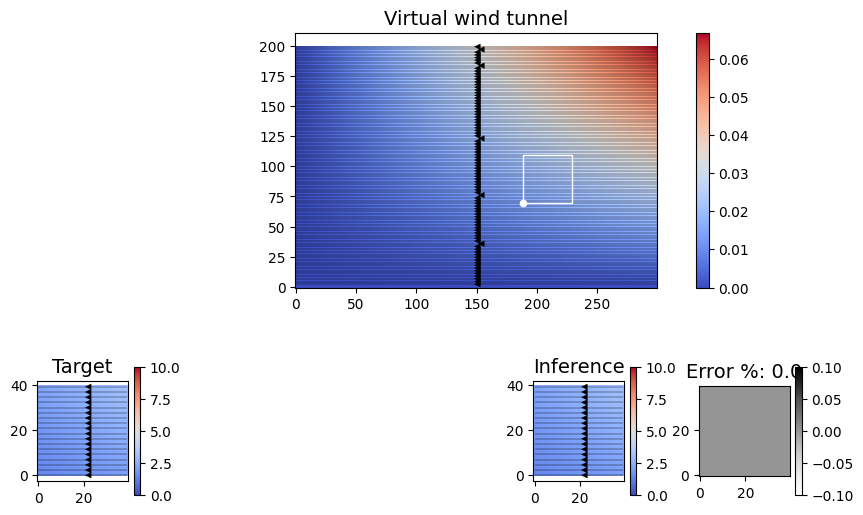

In [251]:
plt = new_test_env.render(quantity=np.abs(divergence[0,:,:]),
                          camera_position=camera_position,
                          c='white',
                          s=20,
                          lw=1,
                          normalize_cbars=True,
                          cmap='coolwarm',
                          add_streamplot=True,
                          streamplot_density=3,
                          streamplot_color='k',
                          streamplot_linewidth=0.3,
                          figsize=(10,6), 
                          filename=None);

We are going to use the reward based on divergence:

In [252]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting regions of high divergence:

In [253]:
def reward_transformation(div): 
    return float(np.mean(np.abs(div)))

We are going to take a number of steps in the test environment:

In [254]:
n_steps = 50

In [255]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [256]:
camera_position, cues = new_test_env.reset(imposed_camera_position=(150,50))

In [257]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = trained_q_network(cues, training=False)

    action = np.argmax(q_values)

    print(new_test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = new_test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=10,
                                                  verbose=False)

Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Right
Down
Right
Right
Right
Down
Right
Right
Right
Down
Right
Right
Right
Down
Right
Right
Right
Right
Right
Right
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down
Down


The figure below visualizes the camera trajectory that results from the learned policy. 
Note that the agent correctly moves the camera towards the region of highest divergence.

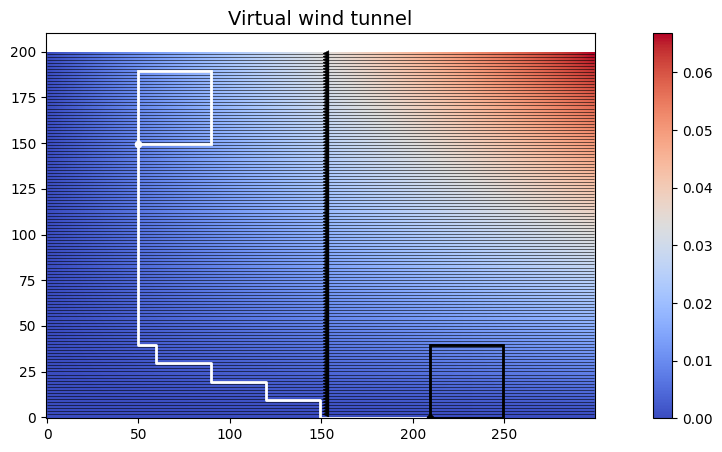

In [258]:
if save_images: filename='test-trajectory.png'
plot_trajectory(saved_camera_trajectories,
                quantity=np.abs(divergence[0,:,:]),
                vector_field=new_test_env.flowfield.velocity_field,
                interrogation_window_size=interrogation_window_size,
                interrogation_window_size_buffer=interrogation_window_size_buffer,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap='coolwarm',
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=filename);

Create sparse samples of camera position on a uniform grid:

In [259]:
(_, _, H, W) = new_test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = new_test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

41600


In [260]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = new_test_env.reset(imposed_camera_position=camera_position)
        q_values = trained_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic)/60:0.1f} min.')

	Time it took: 3.1 min.


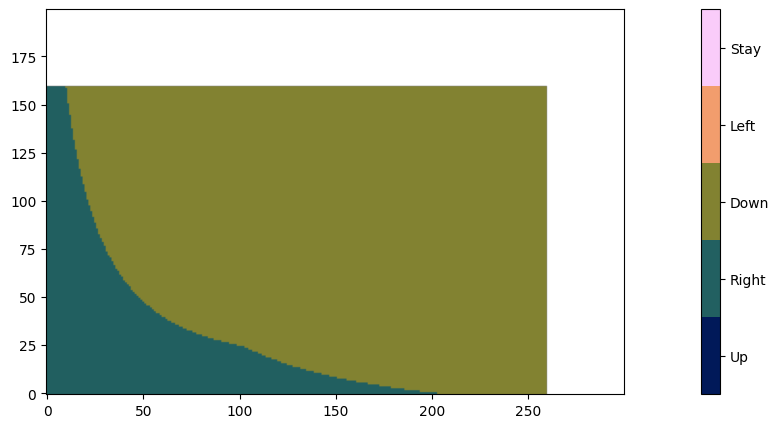

In [261]:
plt.figure(figsize=(20,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(new_test_env.action_to_verbose_direction.values()))

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)